# Experiments with natural gradient, constrained optimisation, and MCE IRL

This notebook contains the source for Sam's EE227C project. The aim is to apply (efficiently, somehow) natural gradient learning to maximum causal entropy IRL.

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy

import imitation.tabular_irl as tirl
import imitation.model_env as menv

sns.set(context='notebook', style='darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


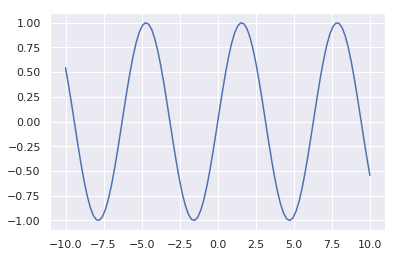

In [8]:
x = np.linspace(-10, 10, 100)
y = np.sin(x)
sns.lineplot(x=x, y=y)
plt.show()

In [114]:
mdp = menv.RandomMDP(
    n_states=16,
    n_actions=3,
    branch_factor=2,
    horizon=20,
    random_obs=True,
    obs_dim=5,
    generator_seed=42)
V, Q, pi = tirl.mce_partition_fh(mdp)
Dt, D = tirl.mce_occupancy_measures(mdp, pi=pi)
demo_counts = D @ mdp.observation_matrix
init_weights = np.random.randn(*demo_counts.shape)
# opt = tirl.AMSGrad(init_weights, alpha=0.1)
# final_weights, final_counts = tirl.maxent_irl(
#     mdp, opt, demo_counts, linf_eps=1e-4)
# print('Final 2-norm of feature count differences:', np.linalg.norm(final_counts - demo_counts))
# print('Final 2-dist in recovered weights & real ones:', np.linalg.norm(final_weights - mdp._reward_weights))

In [115]:
opt = tirl.SGD(init_weights, alpha=0.1)
final_weights, final_counts = tirl.maxent_irl_ng(
    mdp, opt, demo_counts, linf_eps=1e-4)

Feature count error@iter   0: 19.757751 (||params||=1.755062, ||grad||=27.852049, ||fcount||=21.798477, ||step||=2.974122)
Feature count error@iter  10: 8.632837 (||params||=0.660626, ||grad||=12.610677, ||fcount||=17.411069, ||step||=0.467708)
Feature count error@iter  20: 4.416367 (||params||=0.561158, ||grad||=6.206724, ||fcount||=18.676139, ||step||=0.404367)
Feature count error@iter  30: 2.237201 (||params||=0.604432, ||grad||=3.268211, ||fcount||=19.353659, ||step||=0.233039)
Feature count error@iter  40: 1.203868 (||params||=0.688621, ||grad||=1.779320, ||fcount||=19.893479, ||step||=0.107477)
Feature count error@iter  50: 0.718617 (||params||=0.765815, ||grad||=1.009782, ||fcount||=20.193270, ||step||=0.045760)
Feature count error@iter  60: 0.421176 (||params||=0.812763, ||grad||=0.603318, ||fcount||=20.399309, ||step||=0.041348)
Feature count error@iter  70: 0.239954 (||params||=0.843844, ||grad||=0.385524, ||fcount||=20.535028, ||step||=0.028899)
Feature count error@iter  80:

In [135]:
opt = tirl.SGD(init_weights, alpha=1)
final_weights, final_counts = tirl.maxent_irl_ng(
    mdp, opt, demo_counts, linf_eps=1e-4)

Feature count error@iter   0: 19.757751 (||params||=1.755062, ||grad||=27.852049, ||fcount||=21.798477, ||step||=3.358108)
Feature count error@iter  10: 0.003418 (||params||=0.903901, ||grad||=0.004559, ||fcount||=20.686474, ||step||=0.001456)
Feature count error@iter  20: 0.000086 (||params||=0.905509, ||grad||=0.000116, ||fcount||=20.687383, ||step||=0.000021)


In [123]:
opt = tirl.SGD(init_weights, alpha=0.02)
final_weights, final_counts = tirl.maxent_irl(
    mdp, opt, demo_counts, linf_eps=1e-4)

Feature count error@iter   0: 19.757751 (||params||=1.755062, ||grad||=27.852049, ||fcount||=21.798477)
Feature count error@iter  10: 1.402962 (||params||=0.955278, ||grad||=2.153202, ||fcount||=19.596933)
Feature count error@iter  20: 0.495535 (||params||=0.888911, ||grad||=0.712016, ||fcount||=20.350013)
Feature count error@iter  30: 0.365933 (||params||=0.851637, ||grad||=0.463687, ||fcount||=20.490907)
Feature count error@iter  40: 0.290692 (||params||=0.837765, ||grad||=0.354749, ||fcount||=20.537042)
Feature count error@iter  50: 0.234167 (||params||=0.837089, ||grad||=0.281940, ||fcount||=20.565882)
Feature count error@iter  60: 0.188935 (||params||=0.842405, ||grad||=0.226504, ||fcount||=20.588551)
Feature count error@iter  70: 0.152438 (||params||=0.849925, ||grad||=0.182536, ||fcount||=20.607033)
Feature count error@iter  80: 0.122994 (||params||=0.857825, ||grad||=0.147251, ||fcount||=20.622133)
Feature count error@iter  90: 0.099250 (||params||=0.865274, ||grad||=0.118837, 